# **Импорт важных библиотек**





In [ ]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего

import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации

from sklearn.datasets import make_moons, make_blobs # генерируемые наборы данных

from matplotlib.colors import ListedColormap # функция библиотеки Matplotlib, которая генерирует цветовую карту

In [ ]:
def plot_data(ax,X,n_inliers,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    """Визуализация двумерных  данных для поиска аномалий
    Входные переменные:
    ===========
    ax: отдельная ячейка объекта figure
    X: набор данных, содержащий признаки X
    n_inliers: количество нормальных данных
    name: название графика
    marker: тип маркера - по умолчанию просто круги
    colors: цвета, которые будут использоваться для раскраски разных классов - по умолчанию Красный и Синий
    alpha: прозрачность маркеров
    s: размер маркера (~ квадрат радиуса)
    facecolor:
    """


    ax.set_title(name, fontsize = 30) # прописываем название графика
    ax.scatter(X[:n_inliers, 0], X[:n_inliers, 1],
                marker = marker, c=colors[0],
                s = s,
                alpha =alpha)
    ax.scatter(X[n_inliers:, 0], X[n_inliers:, 1],
            marker = marker, c=colors[1],
            s = s,
            alpha =alpha)
    # немного красоты и аккуратности
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

# Генерация данных

Данные будут содержать две составляющие:


*  Нормальные данные принадлижащие некому распределению (`inlier`)
*  Случайный шум (`outlier`)


Начнем с нормальных данных, которых будет 3 варианта

* Нормальное распределение
* Бимодальное нормальное распределение
* Ненормальное "структурированное" распределение



In [ ]:
# Общие параметры связанные с количеством
n_samples = 300 # Количество точек всего
outliers_fraction = 0.15 # доля аномалий
n_outliers = int(outliers_fraction * n_samples) # количество аномалий в штуках
n_inliers = n_samples - n_outliers # количество нормальных точек в штуках

# Три набора двумерных данных

# общие параметры для данных в виде скоплений точек
blobs_params = dict(random_state=42, n_samples=n_inliers, n_features=2)

# 1 кластер с центром в [0, 0] и СКО 0.5
data_normal, _ = make_blobs(centers=[[0, 0], ], cluster_std=0.5, **blobs_params)

# 2 кластера с центрами в [2, 2] и [-2, -2] и СКО [1.5, 0.3]
data_bimodal, _ = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)


# 2 кластера в форме полумесецев
data_moons = 4.0* (make_moons(n_samples=n_inliers, noise=0.05, random_state=0)[0] - np.array([0.5, 0.25]))


Добавим к этим данным шум

Из равномерного распределения с большим разбросом чем нормальные данные

In [ ]:
rng = np.random.RandomState(42)
noise = rng.uniform(low=-6, high=6,
                    size=(n_outliers, 2))

# Добавление случайного шума
data_normal = np.concatenate([data_normal, noise], axis=0)

data_bimodal = np.concatenate([data_bimodal, noise], axis=0)

data_moons = np.concatenate([data_moons, noise], axis=0)

**Визуализация Данных**

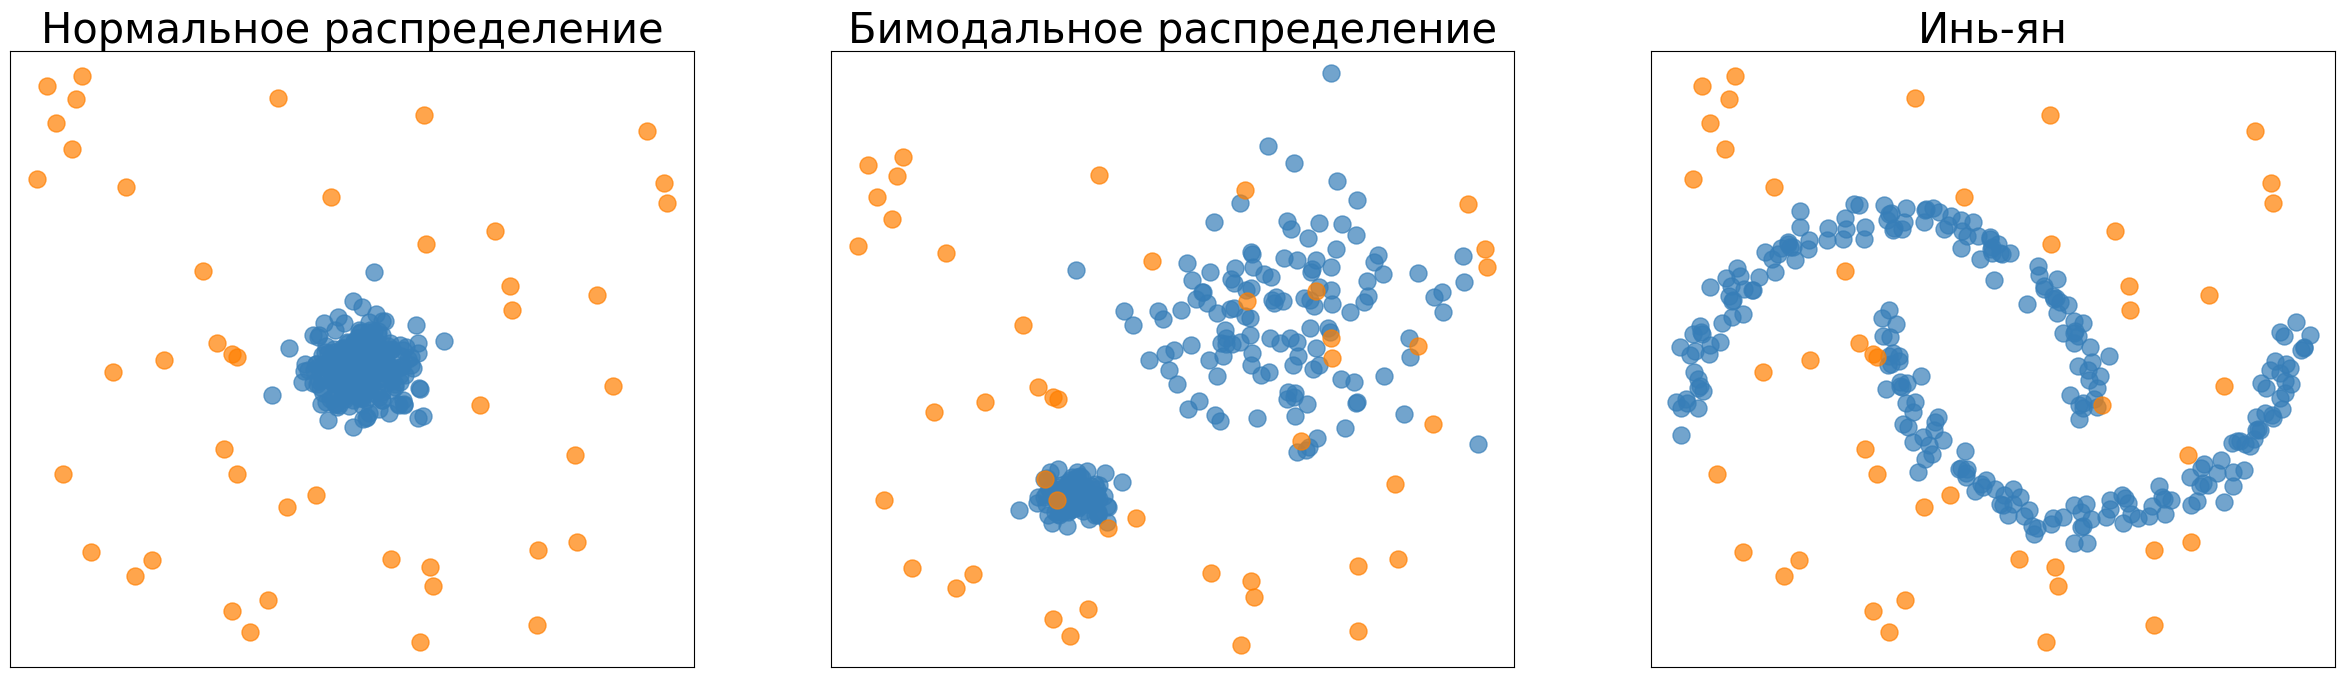

In [ ]:
colors = np.array(["#377eb8","#ff7f00",  ]) # цвета для данных. В этот раз для разнообразия Оранжевый (аномалии) и Синий (нормальные)

fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
plot_data(ax,data_normal,n_inliers,  colors = colors,
          name='Нормальное распределение')
ax = plt.subplot(1, 3, 2)
plot_data(ax,data_bimodal,n_inliers,  colors = colors,
          name='Бимодальное распределение')
ax = plt.subplot(1, 3, 3)
plot_data(ax,data_moons,n_inliers,  colors = colors,
          name='Инь-ян')


Так же нам понадобится визуализации функция принятия решения для разных алгоритмов

Чтобы оценить как методы поиска аномалий будут работать с новыми данными

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay # Класс библиотеки scikit-learn для визуализации границ решений

In [ ]:
def viz_anomaly(data, algorithm, colors, n_inliers = n_inliers, response_method="auto"):
    """Визуализация принятия решений и данных
    Входные переменные:
    ===========
    data: данные которые будем визуализировать
    algorithm: Класс модели машинного обучения для которого мы хотим узнать границы решений
    colors: цвета, которые будут использоваться для раскраски разных классов
    n_inliers: количество нормальных точек в штуках
    response_method: что визуализируем, результаты метода decision_function, predict_proba или predict. auto перебирает первый возможный вариант
    """

    cm_bright = ListedColormap(colors[::-1]) # формируем цветовую карту из наших цветов

    # отрисовываем границу принятия решений с помощью Класса библиотеки scikit-learn
    disp = DecisionBoundaryDisplay.from_estimator(
        algorithm, # Какой алгоритм используем
        data, # на каких данных проверяем
        response_method=response_method, # что визуализируе
        cmap=cm_bright, # какую цветовую карту используем
        alpha=0.5, #прозрачность
    )

    # визуализируем просто данные с помощью нашей функции
    plot_data(disp.ax_,data,n_inliers, colors = colors,)

# **EllipticEnvelope**

In [ ]:
from sklearn.covariance import EllipticEnvelope # Объект scikit-learn для обнаружения аномалий в нормально-распределенных данных

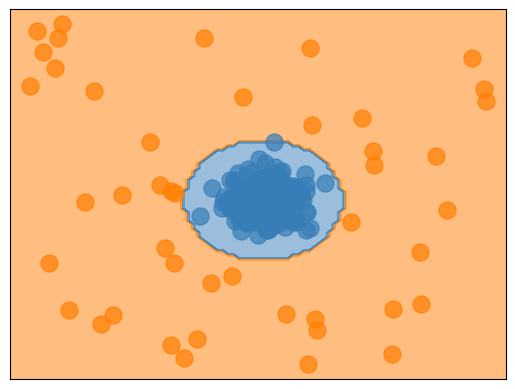

In [ ]:
#@title ### **Гиперпараметры модели** { run: "auto" }
#@markdown ### доля аномальных значений
contamination = 0.15 #@param {type:"slider", min:0.00, max:0.5, step:0.05}
contamination+= 1e-6

# Создаем объект класса
ell_env = EllipticEnvelope(contamination=contamination)
# Обучаем модель
ell_env.fit(data_normal)

# визуализируем результат
viz_anomaly(data_normal, ell_env, colors, response_method="predict");

# Разные атрибуты модели

**Среднее**

In [ ]:
ell_env.location_

array([-0.01582075,  0.00236172])

**Ковариация**

In [ ]:
ell_env.covariance_

array([[0.21770954, 0.00067616],
       [0.00067616, 0.21153991]])

Какие данные использовались для оценки среднего и матрицы ковариации

(в какие данные вписывали эллипсы)

In [ ]:
ell_env.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

# **IsolationForest**

In [ ]:
from sklearn.ensemble import IsolationForest # Объект scikit-learn в котором реализован алгоритм Изолирующий лес

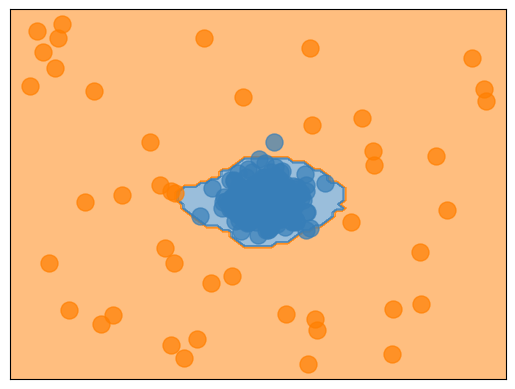

In [ ]:
#@title **Гиперпараметры модели** { run: "auto" }
#@markdown ### доля аномальных значений
contamination = 0.15 #@param {type:"slider", min:0.00, max:0.5, step:0.05}
contamination+= 1e-6
#@markdown ### Количество деревьев
n_estimators =  100 #@param {type:"slider", min:25, max:250 , step:25}
#@markdown ### Фиксируем рандом
random_state=42 #@param {type:"integer"}



# Создаем объект класса
iso_forest = IsolationForest(contamination=contamination,
                            n_estimators = n_estimators,
                            random_state=42)
# Обучаем модель
iso_forest.fit(data_normal)

viz_anomaly(data_normal, iso_forest, colors, response_method="predict");


# Разные атрибуты модели

Методом `.score_samples()` оценивается степень "аномальности" со знаком минус

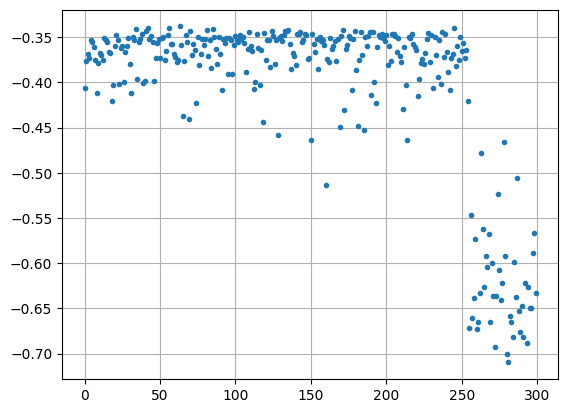

In [ ]:
plt.plot(iso_forest.score_samples(data_normal),'.',)
plt.grid();

# **LocalOutlierFactor**

In [ ]:
from sklearn.neighbors import LocalOutlierFactor # Объект scikit-learn в котором реализован алгоритм Локальный фактор выброса

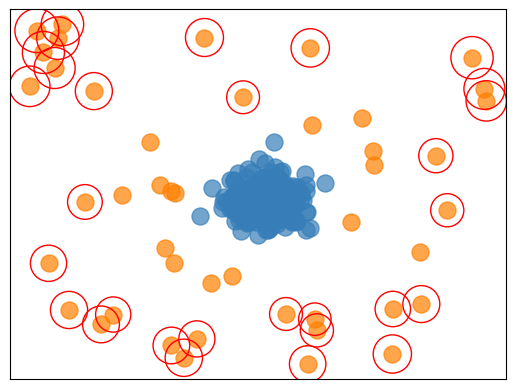

In [ ]:
#@title **Поиск выбросов** { run: "auto" }
#@markdown ### Гиперпараметры модели
#@markdown ### доля аномальных значений
contamination = 0.1 #@param {type:"slider", min:0.00, max:0.5, step:0.05}
#@markdown ### количество к-соседей
n_neighbors = 40 #@param {type:"slider", min:5, max:100, step:5}

contamination+= 1e-6

# Создаем объект класса
lof = LocalOutlierFactor(n_neighbors=n_neighbors,
                               contamination=contamination,
                         )
# Этот метод не такой как остальные методы аномалий
# Поэтому сразу применяется fit_predict для оценки выбросов
y_pred = lof.fit_predict(data_normal)


ax = plt.subplot(1, 1, 1)

plot_data(ax,data_normal,n_inliers, colors = colors,);

# в аттрибуте `.negative_outlier_factor_` хранится локальный фактор выброса
X_scores = lof.negative_outlier_factor_
# нормализуем значения локального фактора выброса
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
# для точек которые мы считаем аномалиями визуализируем локальный фактор выброса
# чем больше радиус круга - тем больше локальный фактор выброса
plt.scatter(
    data_normal[y_pred==-1, 0],
    data_normal[y_pred==-1, 1],
    s=1000 * radius[y_pred==-1],
    edgecolors="r",
    facecolors="none",
);


Если хотите использовать как метод обнаружения новизны

In [ ]:
#@title **Поиск Новизны** { run: "auto" }
#@markdown ### Гиперпараметры модели
#@markdown ### доля аномальных значений
contamination = 0.15 #@param {type:"slider", min:0.00, max:0.5, step:0.05}
#@markdown ### количество к-соседей
n_neighbors = 30 #@param {type:"slider", min:5, max:100, step:5}

contamination+= 1e-6

# Создаем объект класса
lof_novelty = LocalOutlierFactor(n_neighbors=n_neighbors,
                               contamination=contamination,
                               novelty = True # надо специально указать
                         )

# В качестве тренировочных данных возьмем данные с четными индексами
# Обучаем модель
lof_novelty.fit(data_normal[::2])
# В качестве "новых" данных возьмем данные с нечетными индексами
y_pred = lof_novelty.predict(data_normal[1::2])

`1` - нормальная точка

`-1` - аномалия

In [ ]:
y_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

# Разные атрибуты модели

* Методом `.score_samples()` оценивается локальный фактор выбросов со знаком - (минус)

При использовании этого метода каждая новая точка оценивается отдельно с распределением в тренировочной выборке (т.е. плотность новых точек не учитывается)

* для тренировочных данных эти оценки хранятся в аттрибуте `.negative_outlier_factor_`

Если подставить тренировочные данные в `.score_samples()` то получится несколько отличающийся результат


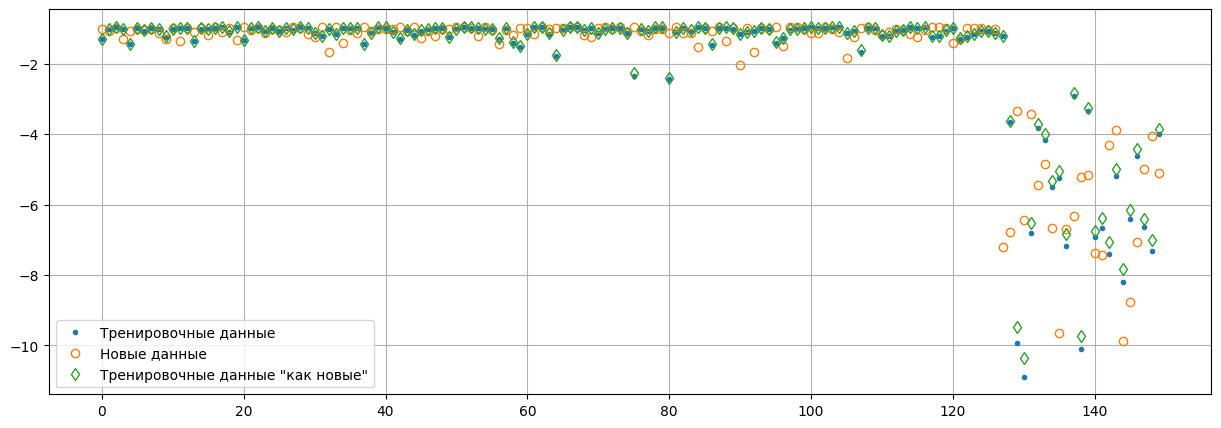

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(lof_novelty.negative_outlier_factor_,'.',
         label = 'Тренировочные данные')
plt.plot(lof_novelty.score_samples(data_normal[1::2]),'o',
         mfc='none',
         label = 'Новые данные' )

plt.plot(lof_novelty.score_samples(data_normal[::2]),'d',
         mfc='none',
         label = 'Тренировочные данные "как новые"' )
plt.legend()
plt.grid();

# Задание


* Проверить алгоритмы поиска аномалий на бимодальных данных и структурированных данных Инь-ян

* Оценить влияние гиперпараметров моделей на результат



In [ ]:
data_bimodal;

In [ ]:
data_moons;